This is described by an equation of the form
$$
\frac1{t^2} \frac{d}{dt}\left(t^2 \frac{d\theta}{dt}\right) + \theta^n = 0
$$

In [1]:
from integrators import contact as ic
from integrators.common import rk4, pad_and_cumsum

In [2]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('fast') #alt: 'seaborn-white'

#plt.rcParams.update({'font.size': 20, 'font.family': 'serif', 'font.weight':'normal'})
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = "serif"
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['mathtext.fontset'] = "cm"

In [3]:
class LaneEmden:
    def __init__(self, n):
        self.n = n

    def f(self, t):
        return 2/t
    
    def V(self, q, t):
        return q**(self.n+1)/(self.n+1)
    
    def Vq(self, q, t):
        return q**self.n

In [4]:
# Core of formulas generated from Mathematica using
# pw = PageWidth /. Options[$Output];
# SetOptions[$Output, PageWidth -> Infinity];
# FortranForm[expression /. \[Tau] -> dt]
# SetOptions[$Output, PageWidth -> pw];

def upper_error_bound(n, m, dt, p, q):
    return np.abs(
        (7*(dt + 2*dt*m)**4*(-2 + n)*(-1 + n)*n*p**3*q**n - 66*(dt + 2*dt*m)**3*(-1 + n)*n*p**2*q**(1 + n) + 16*dt*(1 + 2*m)*q**(2 + n)*((-2 + 60*m*(1 + m))*q + 3*(dt + 2*dt*m)**2*n*q**n) + 4*p*q*(8*(-19 + 120*m*(1 + m))*q**2 - 3*(dt + 2*dt*m)**4*n*(-3 + 4*n)*q**(2*n) - 6*(dt + 2*dt*m)**2*(1 + 20*m*(1 + m))*n*q**(1 + n)))/(1440.*(1 + 2*m)**4*q**3)
    )

def upper_error_bound_p(n, m, dt, p, q):
    return np.abs(
        (192*(-1 + 10*m*(1 + m))*p - 16*(dt + 2*dt*m)**2*(-1 + 30*m*(1 + m))*n*p*q**(-1 + n) - 80*dt*(1 + 2*m)*q**n + 6*(dt + 2*dt*m)**3*n*q**(-2 + n)*((1 + 20*m*(1 + m))*(-1 + n)*p**2 - 16*(1 + 5*m*(1 + m))*q**(1 + n)) + (dt + 2*dt*m)**4*n*p*q**(-3 + n)*(11*(-2 + n)*(-1 + n)*p**2 - 24*(-1 + 2*n)*q**(1 + n)) + ((dt + 2*dt*m)**5*n*q**(-4 + n)*(-7*(-3 + n)*(-2 + n)*(-1 + n)*p**4 + 48*(-1 + n)*(-3 + 4*n)*p**2*q**(1 + n) - 96*(-1 + 3*n)*q**(2 + 2*n)))/8.)/(720.*dt*(1 + 2*m)**5)
    )

total_error_bound = lambda n, m, dt, p, q: np.linalg.norm([upper_error_bound(n, m, dt, p, q),upper_error_bound_p(n, m, dt, p, q)])

In [5]:
dt = 0.01 # run with 0.2 and 0.01

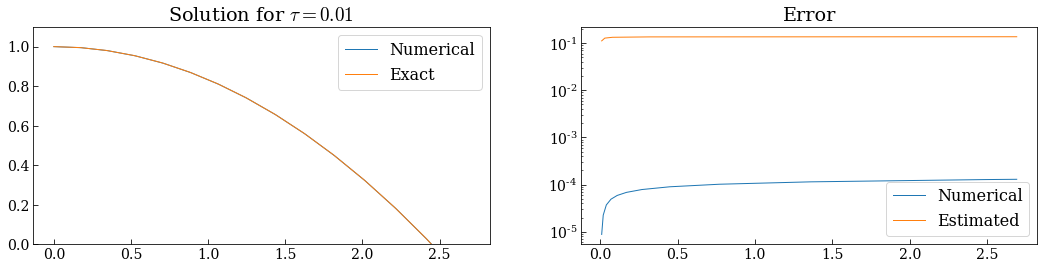

In [6]:
n = 0
le = LaneEmden(n)
tf = 2.7
p0, q0 = (0,1)
tspan = np.arange(0.0, tf, dt)

exact = lambda t: 1-1/6*t**2
errq = lambda m, p0, q0: total_error_bound(n,m,dt,p0,q0)
errp = lambda m, p0, q0: total_error_bound(n,m,dt,p0,q0)

plt.figure(figsize=(18,4))
#plt.suptitle(f"$n={le.n}$, $dt={dt}$")
sol, _, _ = ic.integrate(ic.step, le, tspan, p0, q0, 0.0)

#p1, q1 = sol[:,0][1], sol[:,1][1]
#solm1, _, _ = ic.integrate(ic.step6, le, tspan[1:], p1, q1, 0.0)
#sole1, _, _ = ic.integrate(ic.step6e, le, tspan[1:], p1, q1, 0.0)

plt.subplot(121)
plt.title(f"Solution for $\\tau={dt}$")
plt.plot(tspan, sol[:,1], linewidth=1, label="Numerical")
plt.plot(tspan, exact(tspan),
         linewidth=1, label="Exact")
plt.ylim(0,1.1)
plt.legend()
    
plt.subplot(122)
plt.title("Error")
plt.plot(tspan[1:], abs(sol[:,1]-exact(tspan))[1:], linewidth=1, label="Numerical")
plt.plot(tspan[1:],
         pad_and_cumsum([errq(m,p0,q0) for m, p0, q0 in zip(range(len(tspan)),sol[:,0],sol[:,1])])[1:],
         linewidth=1, label="Estimated")
plt.legend()
plt.yscale("log")
plt.legend()

plt.show()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


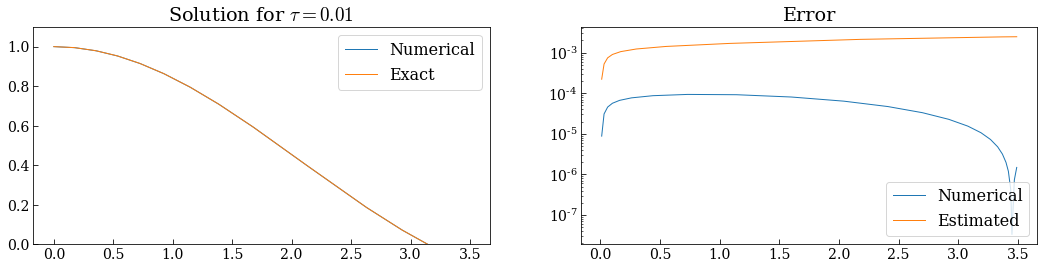

In [7]:
n = 1
le = LaneEmden(n)
tf = 3.5
p0, q0 = (0,1)
tspan = np.arange(0.0, tf, dt)

exact = lambda t: np.sin(t)/t
# Deal with limit t->0 by hand
exact = exact(tspan)
exact[0] = 1.0

errq = lambda m, p0, q0: upper_error_bound(n,m,dt,p0,q0)
errp = lambda m, p0, q0: upper_error_bound_p(n,m,dt,p0,q0)

plt.figure(figsize=(18,4))
#plt.suptitle(f"$n={le.n}$, $dt={dt}$")
sol, _, _ = ic.integrate(ic.step, le, tspan, p0, q0, 0.0)

#p1, q1 = sol[:,0][1], sol[:,1][1]
#solm1, _, _ = ic.integrate(ic.step6, le, tspan[1:], p1, q1, 0.0)
#sole1, _, _ = ic.integrate(ic.step6e, le, tspan[1:], p1, q1, 0.0)

plt.subplot(121)
plt.title(f"Solution for $\\tau={dt}$")
plt.plot(tspan, sol[:,1], linewidth=1, label="Numerical")
plt.plot(tspan, exact,
         linewidth=1, label="Exact")
plt.ylim(0,1.1)
plt.legend()
    
plt.subplot(122)
plt.title("Error")
plt.plot(tspan[1:], abs(sol[:,1]-exact)[1:], linewidth=1, label="Numerical")
plt.plot(tspan[1:],
         pad_and_cumsum([errq(m,p0,q0) for m, p0, q0 in zip(range(len(tspan)),sol[:,0],sol[:,1])])[1:],
         linewidth=1, label="Estimated")
plt.legend()
plt.yscale("log")
plt.legend(loc="lower right")

plt.show()

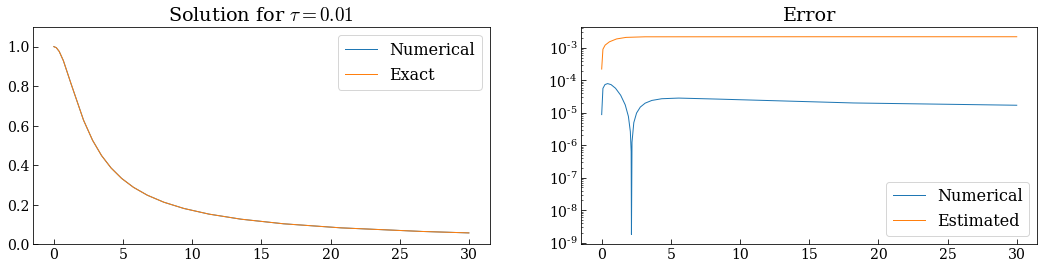

In [8]:
n=5
le = LaneEmden(n)
tf = 30.0
p0, q0 = (0,1)
tspan = np.arange(0.0, tf, dt)

exact = lambda t: 1/np.sqrt(1 + t**2/3)
errq = lambda m, p0, q0: upper_error_bound(n,m,dt,p0,q0)
errp = lambda m, p0, q0: upper_error_bound_p(n,m,dt,p0,q0)

plt.figure(figsize=(18,4))
#plt.suptitle(f"$n={le.n}$, $dt={dt}$")
sol, _, _ = ic.integrate(ic.step, le, tspan, p0, q0, 0.0)

#p1, q1 = sol[:,0][1], sol[:,1][1]
#solm1, _, _ = ic.integrate(ic.step6, le, tspan[1:], p1, q1, 0.0)
#sole1, _, _ = ic.integrate(ic.step6e, le, tspan[1:], p1, q1, 0.0)

plt.subplot(121)
plt.title(f"Solution for $\\tau={dt}$")
plt.plot(tspan, sol[:,1], linewidth=1, label="Numerical")
plt.plot(tspan, exact(tspan),
         linewidth=1, label="Exact")
plt.ylim(0,1.1)
plt.legend()
    
plt.subplot(122)
plt.title("Error")
plt.plot(tspan[1:], abs(sol[:,1]-exact(tspan))[1:], linewidth=1, label="Numerical")
plt.plot(tspan[1:],
         pad_and_cumsum([errq(m,p0,q0) for m, p0, q0 in zip(range(len(tspan)),sol[:,0],sol[:,1])])[1:],
         linewidth=1, label="Estimated")
plt.legend()
plt.yscale("log")
plt.legend()

plt.show()